## CSCI 5654 - Linear Programming - Project

***
#### Team Members
#### 1. Ketan Ramesh
#### 2. Shreyas Gopalakrishna
***

## Vehicle Routing Problem

In [1]:
!pip3 install pulp

In [2]:
!pip3 install ortools

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import random
import pulp
import ortools 

## Vehicle Routing with capacity 
#### Link for paper: https://arxiv.org/pdf/1606.01935.pdf
#### The below code solves the capacited vehicle routing problem by following the methodology mentioned in the above cited paper.
#### The formulation is as follows:

## Capacity Vehicle Routing Problem - Model 1

Paper Link - [A generalized formulation for vehicle routing problems](https://arxiv.org/pdf/1606.01935.pdf)

<div align="justify">
The code provided below creates a <code>class</code> to frame and solve the Capacity Vehicle Routing Problem (CVRP) using the two-index flow formulation as mentioned in the paper. The formulation of the problem as a Mixed ILP is as follows:
</div>

$$
min \sum_{i=0}^{n+1} \sum_{j=0}^{n+1} c_{ij} x_{ij}
$$

$$
s.t. \sum_{j=1, j \neq i}^{n+1} x_{ij} = 1, i = 1, ..., n, - (1.1)
$$

$$
\sum_{i=0, i \neq h}^{n} x_{ih} - \sum_{j=1, j \neq h}^{n+1} x_{hj}
 = 0, h = 1, ..., n, - (1.2)
 $$

$$
\sum_{j=1}^{n} x_{0j} \leq K - (1.3)
$$

$$
y_j \geq y_i + q_j x_{ij} - Q(1 - x_{ij}), i, j = 0, ..., n+1, - (1.4)
$$

$$
q_i \leq y_i \leq Q, i = 0, ..., n+1, - (1.5)
$$

$$
x_{ij} = \{0, 1\}, i, j = 0, ..., n+1.
$$

where,

N customers are denoted by 1, 2, ... n. The depot is denoted as 0 and n+1 respectively.<br />
K = Number of vehicles.<br />
Q = Capacity of the vehicle.<br />
q<sub>i</sub> = Demand of customer i.<br />
c<sub>ij</sub> = Cost incurred on traveling from i to j.<br />

<b>Decision Variables:</b>
1. x<sub>ij</sub> = {<b>1</b>, if edge (i, j) present in any route. <b>0</b>, otherwise}. 

2. y<sub>j</sub> = Cummulative demand on route that visits node j. A continuous non-negative variable.

<div align="justify">
The objective is to minimize the sum of the distances of all routes that satisfy the given constraints. The constraint (1.1) is to ensure that all customer nodes are visited exactly once (each node <i>i</i> visits only one other node <i>j</i>). The constraint (1.2) ensures that if a node is visited, it must depart from the same node (node <i>h</i> visited by only one other node <i>i</i> and in turn visits only one other node <i>j</i>). The constraint (1.3) is used to limit number of different routes/number of vehicles from the depot. The constraints (1.4) and (1.5) is used to eliminate sub-tours and force each route to pass through/include the depot in it.
</div>
 

In [0]:
# PuLP class for vehicle routing

class CVRP:
    def __init__(self, numberOfCustomers, numberOfVehicles, capacityOfVehicle, demandOfCustomers, costMatrix):
        self.numberOfCustomers = numberOfCustomers
        self.numberOfVehicles  = numberOfVehicles
        self.capacityOfVehicle = capacityOfVehicle
        self.demandOfCustomers = demandOfCustomers
        self.costMatrix        = costMatrix
        self.initializeLP()
    
    def initializeLP(self):
        self.cvrpLP = pulp.LpProblem("CVRP", pulp.LpMinimize)
        objective = None
        x,y = [], []
        constraint1 = None
        
        # objective function and variables
        for i in range(len(costMatrix)): #adding depot
            xTemp1 = []
            for j in range(len(costMatrix)):
                if(i != j):
                    xTemp2 = pulp.LpVariable('x('+str(i)+','+str(j)+')', cat='Binary')
                    xTemp1.append(xTemp2)
                    objective += xTemp2 * costMatrix[i][j]
                else:
                    xTemp1.append(None)
            x.append(xTemp1) 
        self.cvrpLP += objective
        
        for i in range(len(costMatrix)):
            y.append(pulp.LpVariable('y'+str(i), lowBound=0, cat='Continuous'))
        
        
        # constraints
        # ensure that all customers are visited exactly once
        for i in range(1, len(costMatrix)-1): #adding depot
            constraint1 = None
            for j in range(1, len(costMatrix)):
                if(i != j):
                    constraint1 += x[i][j]
            self.cvrpLP += constraint1 == 1
        
        # limits the maximum number of routes to the number of vehicles
        constraint2 = None
        for j in range(1, len(costMatrix)-1): #not include depot
            constraint2 += x[0][j]
        self.cvrpLP += constraint2 <= self.numberOfVehicles

        # limits the maximum number of routes to the number of vehicles
        # constraint2 = None
        # for j in range(1, len(costMatrix) - 1): #not include depot
        #     constraint2 += x[j][-1]
        # self.cvrpLP += constraint2 <= self.numberOfVehicles
        
        # ensure together that the vehicle capacity is not exceeded
        for i in range(len(costMatrix)):
            constarint3a, constarint3b  = None, None
            constarint3a = self.demandOfCustomers[i] <= y[i] 
            constarint3b = y[i] <= self.capacityOfVehicle
            self.cvrpLP += constarint3a
            self.cvrpLP += constarint3b
        
        # ensure together that the vehicle capacity is not exceeded
        for i in range(len(costMatrix)): #adding depot
            for j in range(len(costMatrix)):
                constraint4 = None
                if(i != j):
                    constraint4 += y[j] >= y[i] + self.demandOfCustomers[j]*x[i][j] - self.capacityOfVehicle*(1-x[i][j])
                    self.cvrpLP += constraint4
        
        #guarantee the correct flow of vehicles through the arcs, by stating that if a vehicle arrives to a node
        #then it must depart from this node
        for h in range(1, len(costMatrix)-1):
            constraint5a, constraint5b = None, None
            for i in range(0, len(costMatrix)-1):
                if(i != h):
                    constraint5a += x[i][h]
            for j in range(1, len(costMatrix)):
                if(j != h):
                    constraint5b += x[h][j]
            self.cvrpLP += constraint5a - constraint5b == 0
        
        # print(self.cvrpLP)
        
    def solve(self):
        status = self.cvrpLP.solve()
        print(pulp.LpStatus[self.cvrpLP.status])
    
    def getResult(self):
        print("Objective value: ", pulp.value(self.cvrpLP.objective))
        for v in self.cvrpLP.variables():
            print(v.name, " = ", v.varValue)
        return self.cvrpLP


## TESTING - RANDOM DATASET

In [6]:
numberOfCustomers = 5
capacityOfVehicle = 10
numberOfVehicles = 3
C = [i for i in range(1, numberOfCustomers+1)] #set of customers
V = [0] + C + [numberOfCustomers+1] #depot + customer nodes
demandOfCustomers = {1: 1, 2: 5, 3: 8, 4: 5, 5: 5, 0: 0, 6: 0}
# demandOfCustomers[0] = 0
# demandOfCustomers[numberOfCustomers+1] = 0

# Creating random coordinates
xCoordinates = [30, 20, 10, 10, 40, 50, 30]
yCoordinates = [30, 40, 45, 30, 10, 30, 30]

# Cost matrix
costMatrix = np.ndarray(shape=(len(V),len(V)))
for i in range(len(V)):
    for j in range(len(V)):
        if(i == 0 and j == len(V)-1):
            costMatrix[i][j] = 0
            continue
        
        if(j == 0 and i == len(V)-1):
            costMatrix[i][j] = 0
            continue
        
        if(i!=j):
            costMatrix[i][j] = int(distance.euclidean([xCoordinates[i],yCoordinates[i]], [xCoordinates[j],yCoordinates[j]]))
        else:
            costMatrix[i][j] = 0
print(costMatrix)
print(demandOfCustomers)

[[ 0. 14. 25. 20. 22. 20.  0.]
 [14.  0. 11. 14. 36. 31. 14.]
 [25. 11.  0. 15. 46. 42. 25.]
 [20. 14. 15.  0. 36. 40. 20.]
 [22. 36. 46. 36.  0. 22. 22.]
 [20. 31. 42. 40. 22.  0. 20.]
 [ 0. 14. 25. 20. 22. 20.  0.]]
{1: 1, 2: 5, 3: 8, 4: 5, 5: 5, 0: 0, 6: 0}


In [7]:
lp = CVRP(numberOfCustomers, numberOfVehicles, capacityOfVehicle, demandOfCustomers, costMatrix)
lp.solve()
result = lp.getResult()

Optimal
Objective value:  154.0
x(0,1)  =  1.0
x(0,2)  =  0.0
x(0,3)  =  1.0
x(0,4)  =  1.0
x(0,5)  =  0.0
x(0,6)  =  0.0
x(1,0)  =  0.0
x(1,2)  =  1.0
x(1,3)  =  0.0
x(1,4)  =  0.0
x(1,5)  =  0.0
x(1,6)  =  0.0
x(2,0)  =  0.0
x(2,1)  =  0.0
x(2,3)  =  0.0
x(2,4)  =  0.0
x(2,5)  =  0.0
x(2,6)  =  1.0
x(3,0)  =  0.0
x(3,1)  =  0.0
x(3,2)  =  0.0
x(3,4)  =  0.0
x(3,5)  =  0.0
x(3,6)  =  1.0
x(4,0)  =  0.0
x(4,1)  =  0.0
x(4,2)  =  0.0
x(4,3)  =  0.0
x(4,5)  =  1.0
x(4,6)  =  0.0
x(5,0)  =  0.0
x(5,1)  =  0.0
x(5,2)  =  0.0
x(5,3)  =  0.0
x(5,4)  =  0.0
x(5,6)  =  1.0
x(6,0)  =  0.0
x(6,1)  =  0.0
x(6,2)  =  0.0
x(6,3)  =  0.0
x(6,4)  =  0.0
x(6,5)  =  0.0
y0  =  0.0
y1  =  1.0
y2  =  10.0
y3  =  10.0
y4  =  5.0
y5  =  10.0
y6  =  10.0


In [8]:
# Use output to get path
# gets variables as (x,y) coordinates
variables = []
for v in result.variables():
    if('x' in v.name and v.varValue == 1):
        # print(v.name, " = ", v.varValue)
        temp = (v.name.split('(')[1].split(')')[0].split(','))
        variables.append((int(temp[0]),int(temp[1])))
# print(variables)

# recursive calls for getting the path
def recursiveList(start, L, X):
    for item in L:
        if(item[0] == start):
            X.append(item)
            return recursiveList(item[1], L, X)
    return X

pathList = []
setList = []
start = 0
for v in variables:
    if(v[0] == start):
        path = recursiveList(v[1], variables, [v])
        print(path)
        pathList.append(path)
        set1 = []
        for i in path:
            set1.append(i[0])
            set1.append(i[1])
        setList.append(list(set(set1)))

[(0, 1), (1, 2), (2, 6)]
[(0, 3), (3, 6)]
[(0, 4), (4, 5), (5, 6)]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


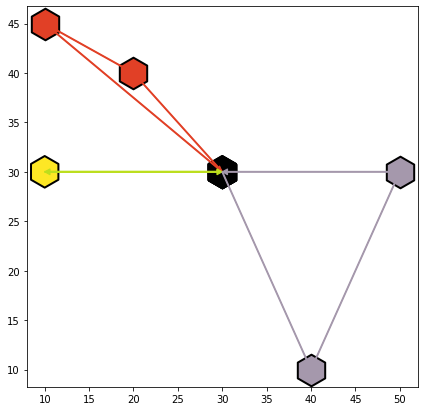

In [10]:
# Visualization
plt.figure(figsize=(7,7))
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

coordinateList = []
for s in setList:
    coordinate = []
    for j in s:
        coordinate.append([float(xCoordinates[j]), float(yCoordinates[j])])
    coordinateList.append(coordinate)
# print(coordinateList)

def addToPlot(L):
    x_val = [x[0] for x in L]
    y_val = [x[1] for x in L]

    r = random.random()
    b = random.random()
    g = random.random()
    newColor = (r, g, b)
    
    plt.scatter(x_val,y_val, c=newColor, edgecolor='black', linewidth=2, s=1000, marker='h')
    ax = plt.axes()
    
    length = len(L)-1
    
    for i in range(length):
        ax.arrow(L[i][0],  #x1
                    L[i][1],  # y1
                    L[i+1][0]-L[i][0], # x2 - x1
                    L[i+1][1]-L[i][1], # y2 - y1
                    width=0.1, head_width=0.6, head_length=0.6, color=newColor, length_includes_head=True,
                    )
    
    # ax.arrow(L[-1][0],  #x1
    #                 L[-1][1],  # y1
    #                 L[0][0]-L[-1][0], # x2 - x1
    #                 L[0][1]-L[-1][1], # y2 - y1
    #                 width=0.1, head_width=0.6, head_length=0.6, color=newColor, length_includes_head=True,
    #                 )
for i in range(len(coordinateList)):
    addToPlot(coordinateList[i])
plt.scatter(coordinateList[0][0][0],coordinateList[0][0][1], c='black', edgecolor='black', linewidth='2', s=1000, marker='h')
plt.show()

## TESTING WITH PRE_DEFINED DATA N=15


In [11]:
# Data Source: 
numberOfCustomers = 15
capacityOfVehicle = 35
numberOfVehicles = 8
C = [i for i in range(1, numberOfCustomers+1)] #set of customers
V = [0] + C + [numberOfCustomers+1] #depot + customer nodes
demandOfCustomers = {0:0,1:19,2:30,3:16,4:23,5:11,6:31,7:15,8:28,9:8,10:8,11:7,12:14,13:6,14:19,15:11}
# demandOfCustomers[0] = 0
demandOfCustomers[numberOfCustomers+1] = 0

xCoordinates = [30,37,49,52,31,52,42,52,57,62,42,27,43,58,58,37,30]
yCoordinates = [40,52,49,64,62,33,41,41,58,42,57,68,67,48,27,69,40]

# Cost matrix
costMatrix = np.ndarray(shape=(len(V),len(V)))
for i in range(len(V)):
    for j in range(len(V)):
        if(i == 0 and j == len(V)-1):
            costMatrix[i][j] = 0
            continue
        
        if(j == 0 and i == len(V)-1):
            costMatrix[i][j] = 0
            continue
        
        if(i!=j):
            costMatrix[i][j] = int(distance.euclidean([xCoordinates[i],yCoordinates[i]], [xCoordinates[j],yCoordinates[j]]))
        else:
            costMatrix[i][j] = 0
costMatrix

array([[ 0., 13., 21., 32., 22., 23., 12., 22., 32., 32., 20., 28., 29.,
        29., 30., 29.,  0.],
       [13.,  0., 12., 19., 11., 24., 12., 18., 20., 26.,  7., 18., 16.,
        21., 32., 17., 13.],
       [21., 12.,  0., 15., 22., 16., 10.,  8., 12., 14., 10., 29., 18.,
         9., 23., 23., 21.],
       [32., 19., 15.,  0., 21., 31., 25., 23.,  7., 24., 12., 25.,  9.,
        17., 37., 15., 32.],
       [22., 11., 22., 21.,  0., 35., 23., 29., 26., 36., 12.,  7., 13.,
        30., 44.,  9., 22.],
       [23., 24., 16., 31., 35.,  0., 12.,  8., 25., 13., 26., 43., 35.,
        16.,  8., 39., 23.],
       [12., 12., 10., 25., 23., 12.,  0., 10., 22., 20., 16., 30., 26.,
        17., 21., 28., 12.],
       [22., 18.,  8., 23., 29.,  8., 10.,  0., 17., 10., 18., 36., 27.,
         9., 15., 31., 22.],
       [32., 20., 12.,  7., 26., 25., 22., 17.,  0., 16., 15., 31., 16.,
        10., 31., 22., 32.],
       [32., 26., 14., 24., 36., 13., 20., 10., 16.,  0., 25., 43., 31.,
         

In [12]:
lp = CVRP(numberOfCustomers, numberOfVehicles, capacityOfVehicle, demandOfCustomers, costMatrix)
lp.solve()
result = lp.getResult()

Optimal
Objective value:  444.0
x(0,1)  =  1.0
x(0,10)  =  1.0
x(0,11)  =  1.0
x(0,12)  =  0.0
x(0,13)  =  1.0
x(0,14)  =  1.0
x(0,15)  =  0.0
x(0,16)  =  0.0
x(0,2)  =  1.0
x(0,3)  =  0.0
x(0,4)  =  0.0
x(0,5)  =  1.0
x(0,6)  =  1.0
x(0,7)  =  0.0
x(0,8)  =  0.0
x(0,9)  =  0.0
x(1,0)  =  0.0
x(1,10)  =  0.0
x(1,11)  =  0.0
x(1,12)  =  0.0
x(1,13)  =  0.0
x(1,14)  =  0.0
x(1,15)  =  0.0
x(1,16)  =  1.0
x(1,2)  =  0.0
x(1,3)  =  0.0
x(1,4)  =  0.0
x(1,5)  =  0.0
x(1,6)  =  0.0
x(1,7)  =  0.0
x(1,8)  =  0.0
x(1,9)  =  0.0
x(10,0)  =  0.0
x(10,1)  =  0.0
x(10,11)  =  0.0
x(10,12)  =  1.0
x(10,13)  =  0.0
x(10,14)  =  0.0
x(10,15)  =  0.0
x(10,16)  =  0.0
x(10,2)  =  0.0
x(10,3)  =  0.0
x(10,4)  =  0.0
x(10,5)  =  0.0
x(10,6)  =  0.0
x(10,7)  =  0.0
x(10,8)  =  0.0
x(10,9)  =  0.0
x(11,0)  =  0.0
x(11,1)  =  0.0
x(11,10)  =  0.0
x(11,12)  =  0.0
x(11,13)  =  0.0
x(11,14)  =  0.0
x(11,15)  =  0.0
x(11,16)  =  0.0
x(11,2)  =  0.0
x(11,3)  =  0.0
x(11,4)  =  1.0
x(11,5)  =  0.0
x(11,6)  =  0.

In [13]:
# Use output to get path
# gets variables as (x,y) coordinates
variables = []
for v in result.variables():
    if('x' in v.name and v.varValue == 1):
        # print(v.name, " = ", v.varValue)
        temp = (v.name.split('(')[1].split(')')[0].split(','))
        variables.append((int(temp[0]),int(temp[1])))
# print(variables)

# recursive calls for getting the path
def recursiveList(start, L, X):
    for item in L:
        if(item[0] == start):
            X.append(item)
            return recursiveList(item[1], L, X)
    return X

pathList = []
setList = []
start = 0
for v in variables:
    if(v[0] == start):
        path = recursiveList(v[1], variables, [v])
        print(path)
        pathList.append(path)
        set1 = []
        for i in path:
            set1.append(i[0])
            set1.append(i[1])
        a = list(set(set1))
        setList.append(sorted(a))
print(setList)

[(0, 1), (1, 16)]
[(0, 10), (10, 12), (12, 15), (15, 16)]
[(0, 11), (11, 4), (4, 16)]
[(0, 13), (13, 8), (8, 16)]
[(0, 14), (14, 7), (7, 16)]
[(0, 2), (2, 16)]
[(0, 5), (5, 9), (9, 3), (3, 16)]
[(0, 6), (6, 16)]
[[0, 1, 16], [0, 10, 12, 15, 16], [0, 4, 11, 16], [0, 8, 13, 16], [0, 7, 14, 16], [0, 2, 16], [0, 3, 5, 9, 16], [0, 6, 16]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric 

[[30.0, 40.0], [37.0, 52.0], [30.0, 40.0]]
[[30.0, 40.0], [42.0, 57.0], [43.0, 67.0], [37.0, 69.0], [30.0, 40.0]]
[[30.0, 40.0], [31.0, 62.0], [27.0, 68.0], [30.0, 40.0]]
[[30.0, 40.0], [57.0, 58.0], [58.0, 48.0], [30.0, 40.0]]
[[30.0, 40.0], [52.0, 41.0], [58.0, 27.0], [30.0, 40.0]]
[[30.0, 40.0], [49.0, 49.0], [30.0, 40.0]]
[[30.0, 40.0], [52.0, 64.0], [52.0, 33.0], [62.0, 42.0], [30.0, 40.0]]
[[30.0, 40.0], [42.0, 41.0], [30.0, 40.0]]


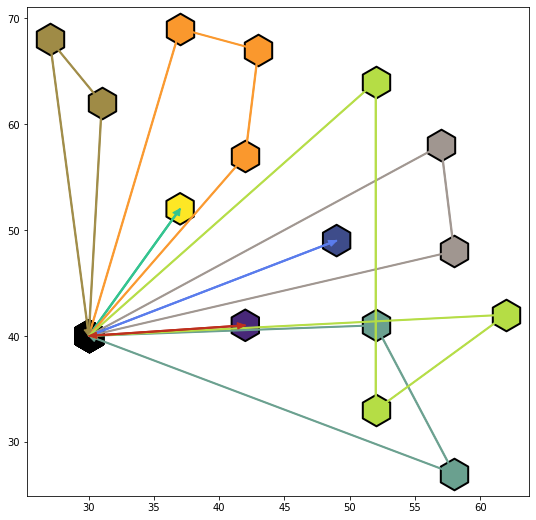

In [16]:
# Visualization
plt.figure(figsize=(9,9))
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

coordinateList = []
for s in setList:
    coordinate = []
    for j in s:
        coordinate.append([float(xCoordinates[j]), float(yCoordinates[j])])
    coordinateList.append(coordinate)
# print(coordinateList)

def addToPlot(L):
    x_val = [x[0] for x in L]
    y_val = [x[1] for x in L]

    r = random.random()
    b = random.random()
    g = random.random()
    newColor = (r, g, b)
    
    plt.scatter(x_val,y_val, c=newColor, edgecolor='black', linewidth=2, s=1000, marker='h')
    ax = plt.axes()
    
    length = len(L)-1
    
    for i in range(length):
        ax.arrow(L[i][0],  #x1
                    L[i][1],  # y1
                    L[i+1][0]-L[i][0], # x2 - x1
                    L[i+1][1]-L[i][1], # y2 - y1
                    width=0.1, head_width=0.6, head_length=0.6, color=newColor, length_includes_head=True,
                    )
    
    # ax.arrow(L[-1][0],  #x1
    #                 L[-1][1],  # y1
    #                 L[0][0]-L[-1][0], # x2 - x1
    #                 L[0][1]-L[-1][1], # y2 - y1
    #                 width=0.1, head_width=0.6, head_length=0.6, color=newColor, length_includes_head=True,
    #                 )
for i in range(len(coordinateList)):
    print(coordinateList[i])
    addToPlot(coordinateList[i])
plt.scatter(coordinateList[0][0][0],coordinateList[0][0][1], c='black', edgecolor='black', linewidth='2', s=1000, marker='h')
plt.show()